<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/6_advanced_adaptation_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アドバンストな共分散行列の適応方法

これまでの議論では理解を簡単にするために，rank-$\mu$ update と呼ばれる，著者が最も簡単に理解できるであろうと考える共分散行列の更新方法のみに着目してアルゴリズムを紹介してきた．

最新のCMA-ES（dd-CMA-ES[1]）では，rank-one update[2]，rank-$\mu$ update[3]，active update[4]，diagonal acceleration[1]を組み合わせることで，より効率的な共分散行列の学習を可能としている．これまでに紹介してきた rank-$\mu$ updateを基準にした場合，それぞれのコンポーネントには以下のような利点がある：

* rank-one update：集団サイズが小さい場合に効率的．共分散行列のうち，固有値の大きな成分を学習する際に効率的．

* active update：共分散行列のうち，固有値の小さな成分を学習する際に効率的．

* diagonal acceleration：共分散行列の対角成分（分散行列）を学習する際に効率的．

ここでは，それぞれのコンポーネントについて紹介していく．

[1] Y. Akimoto, N. Hansen; Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies. Evol Comput 2020; 28 (3): 405–435. doi: https://doi.org/10.1162/evco_a_00260

[2] N. Hansen and A. Ostermeier, "Completely Derandomized Self-Adaptation in Evolution Strategies," in Evolutionary Computation, vol. 9, no. 2, pp. 159-195, June 2001, doi: 10.1162/106365601750190398.

[3] Hansen N, Müller SD, Koumoutsakos P. Reducing the time complexity of the derandomized evolution strategy with covariance matrix adaptation (CMA-ES). Evol Comput. 2003 Spring;11(1):1-18. doi: 10.1162/106365603321828970. PMID: 12804094.

[4] G. A. Jastrebski and D. V. Arnold, "Improving Evolution Strategies through Active Covariance Matrix Adaptation," 2006 IEEE International Conference on Evolutionary Computation, Vancouver, BC, Canada, 2006, pp. 2814-2821, doi: 10.1109/CEC.2006.1688662.

## dd-CMA-ES のコード

以下で説明する更新方法を全て含むdd-CMA-ESのコードを以下に示す．
なお，dd-CMA-ESのコード（リスタート戦略や制約対処を含む）は以下にて公開されているので，こちらを参照されたい．

* https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518
* https://github.com/akimotolab/multi-fidelity

In [5]:
# LaTeX コマンドを読み込むための準備（可視化用，1min程度）
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf g

In [6]:
import warnings
from collections import deque
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class DdCma:
    """dd-CMA: CMA-ES with diagonal decoding [1]"""
    
    def __init__(self, xmean0, sigma0, 
                 lam=None,
                 flg_covariance_update=True,
                 flg_variance_update=True,
                 flg_active_update=True,
                 beta_eig=None,
                 beta_thresh=2.):
        """
        Parameters
        ----------
        xmean0 : 1d array-like
            initial mean vector
        sigma0 : 1d array-like
            initial diagonal decoding
        lam : int, optional (default = None)
            population size
        flg_covariance_update : bool, optional (default = True)
            update C if this is True
        flg_variance_update : bool, optional (default = True)
            update D if this is True
        flg_active_update : bool, optional (default = True)
            update C and D with active update
        beta_eig : float, optional (default = None)
            coefficient to control the frequency of matrix decomposition
        beta_thresh : float, optional (default = 2.)
            threshold parameter for beta control
        """
        self.N = len(xmean0)
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))

        # options
        self.flg_covariance_update = flg_covariance_update
        self.flg_variance_update = flg_variance_update
        self.flg_active_update = flg_active_update
        self.beta_eig = beta_eig if beta_eig else 10. * self.N
        self.beta_thresh = beta_thresh
        
        # parameters for recombination and step-size adaptation
        self.lam = lam if lam else 4 + int(3 * math.log(self.N)) 
        assert self.lam > 2
        w = math.log((self.lam + 1) / 2.0) - np.log(np.arange(1, self.lam+1))
        w[w > 0] /= np.sum(np.abs(w[w > 0]))
        w[w < 0] /= np.sum(np.abs(w[w < 0]))
        self.mueff_positive = 1. / np.sum(w[w > 0] ** 2)
        self.mueff_negative = 1. / np.sum(w[w < 0] ** 2)
        self.cm = 1.
        self.cs = (self.mueff_positive + 2.) / (self.N + self.mueff_positive + 5.)
        self.ds = 1. + self.cs + 2. * max(0., math.sqrt((self.mueff_positive - 1.) / (self.N + 1.)) - 1.)
        
        # parameters for covariance matrix adaptation
        expo = 0.75
        mu_prime = self.mueff_positive + 1. / self.mueff_positive - 2. + self.lam / (2. * self.lam + 10.)
        m = self.N * (self.N + 1) / 2
        self.cone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cmu = min(1. - self.cone, mu_prime * self.cone)
        self.cc = math.sqrt(self.mueff_positive * self.cone) / 2.
        self.w = np.array(w)
        self.w[w < 0] *= min(1. + self.cone / self.cmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # parameters for diagonal decoding
        m = self.N
        self.cdone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cdmu = min(1. - self.cdone, mu_prime * self.cdone)
        self.cdc = math.sqrt(self.mueff_positive * self.cdone) / 2.
        self.wd = np.array(w)
        self.wd[w < 0] *= min(1. + self.cdone / self.cdmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # dynamic parameters
        self.xmean = np.array(xmean0)
        self.D = np.array(sigma0)
        self.sigma = 1.
        self.C = np.eye(self.N)
        self.S = np.ones(self.N)
        self.B = np.eye(self.N)
        self.sqrtC = np.eye(self.N)
        self.invsqrtC = np.eye(self.N)
        self.Z = np.zeros((self.N, self.N))
        self.pc = np.zeros(self.N)
        self.pdc = np.zeros(self.N)
        self.ps = np.zeros(self.N)
        self.pc_factor = 0.
        self.pdc_factor = 0.
        self.ps_factor = 0.

        # others 
        self.teig = max(1, int(1. / (self.beta_eig * (self.cone + self.cmu))))
        self.neval = 0
        self.t = 0
        self.beta = 1.
        
        # strage for checker and logger
        self.arf = np.zeros(self.lam)
        self.arx = np.zeros((self.lam, self.N))

    def transform(self, z):
        y = np.dot(z, self.sqrtC) if self.flg_covariance_update else z
        return y * (self.D * self.sigma)

    def transform_inverse(self, y):
        z = y / (self.D * self.sigma)
        return np.dot(z, self.invsqrtC) if self.flg_covariance_update else z

    def sample(self):
        arz = np.random.randn(self.lam, self.N)
        ary = np.dot(arz, self.sqrtC) if self.flg_covariance_update else arz
        arx = ary * (self.D * self.sigma) + self.xmean
        return arx, ary, arz

    def update(self, idx, arx, ary, arz):
        # shortcut
        w = self.w
        wc = self.w
        wd = self.wd
        sarz = arz[idx]
        sary = ary[idx]
        sarx = arx[idx]
        
        # recombination
        dz = np.dot(w[w > 0], sarz[w > 0])
        dy = np.dot(w[w > 0], sary[w > 0])
        self.xmean += self.cm * self.sigma * self.D * dy

        # step-size adaptation        
        self.ps_factor = (1 - self.cs) ** 2 * self.ps_factor + self.cs * (2 - self.cs)
        self.ps = (1 - self.cs) * self.ps + math.sqrt(self.cs * (2 - self.cs) * self.mueff_positive) * dz
        normsquared = np.sum(self.ps * self.ps)
        hsig = normsquared / self.ps_factor / self.N < 2.0 + 4.0 / (self.N + 1)
        self.sigma *= math.exp((math.sqrt(normsquared) / self.chiN - math.sqrt(self.ps_factor)) * self.cs / self.ds)

        # C (intermediate) update
        if self.flg_covariance_update:
            # Rank-mu
            if self.cmu == 0:
                rank_mu = 0.
            elif self.flg_active_update:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
                rank_mu += np.dot(sarz[wc<0].T * (wc[wc<0] * self.N / np.linalg.norm(sarz[wc<0], axis=1) ** 2),
                                  sarz[wc<0]) - np.sum(wc[wc<0]) * np.eye(self.N)
            else:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
            # Rank-one
            if self.cone == 0:
                rank_one = 0.
            else:
                self.pc = (1 - self.cc) * self.pc + hsig * math.sqrt(self.cc * (2 - self.cc) * self.mueff_positive) * self.D * dy 
                self.pc_factor = (1 - self.cc) ** 2 * self.pc_factor + hsig * self.cc * (2 - self.cc)
                zpc = np.dot(self.pc / self.D, self.invsqrtC)
                rank_one = np.outer(zpc, zpc) - self.pc_factor * np.eye(self.N)
            # Update
            self.Z += (self.cmu * rank_mu + self.cone * rank_one)

        # D update
        if self.flg_variance_update:
            # Cumulation
            self.pdc = (1 - self.cdc) * self.pdc + hsig * math.sqrt(self.cdc * (2 - self.cdc) * self.mueff_positive) * self.D * dy
            self.pdc_factor = (1 - self.cdc) ** 2 * self.pdc_factor + hsig * self.cdc * (2 - self.cdc)
            DD = self.cdone * (np.dot(self.pdc / self.D, self.invsqrtC) ** 2 - self.pdc_factor)
            if self.flg_active_update:
                # positive and negative update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD += self.cdmu * np.dot(wd[wd<0] * self.N / np.linalg.norm(sarz[wd<0], axis=1)**2, sarz[wd<0]**2)
                DD -= self.cdmu * np.sum(wd)
            else:
                # positive update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD -= self.cdmu * np.sum(wd[wd>0])
            if self.flg_covariance_update:
                self.beta = 1 / max(1, np.max(self.S) / np.min(self.S) - self.beta_thresh + 1.)
            else:
                self.beta = 1.
            self.D *= np.exp((self.beta / 2) * DD)

        # update C
        if self.flg_covariance_update and (self.t + 1) % self.teig == 0:
            D = np.linalg.eigvalsh(self.Z)
            fac = min(0.75 / abs(D.min()), 1.)
            self.C = np.dot(np.dot(self.sqrtC, np.eye(self.N) + fac * self.Z), self.sqrtC)            

            # force C to be correlation matrix
            cd = np.sqrt(np.diag(self.C))
            self.D *= cd
            self.C = (self.C / cd).T / cd

            # decomposition
            DD, self.B = np.linalg.eigh(self.C)
            self.S = np.sqrt(DD)
            self.sqrtC = np.dot(self.B * self.S, self.B.T)
            self.invsqrtC = np.dot(self.B / self.S, self.B.T)            
            self.Z[:, :] = 0.

    def onestep(self, func):
        """
        Parameter
        ---------
        func : callable
            parameter : 2d array-like with candidate solutions (x) as elements
            return    : 1d array-like with f(x) as elements
        """
        # sampling
        arx, ary, arz = self.sample()

        # evaluation
        arf = func(arx)
        self.neval += len(arf)
        
        # sort
        idx = np.argsort(arf)
        if not np.all(arf[idx[1:]] - arf[idx[:-1]] > 0.):
            warnings.warn("assumed no tie, but there exists", RuntimeWarning)

        # update
        self.update(idx, arx, ary, arz)

        # finalize
        self.t += 1
        self.arf = arf
        self.arx = arx
        
    @property
    def coordinate_std(self):
        if self.flg_covariance_update:
            return self.sigma * self.D * np.sqrt(np.diag(self.C))
        else:
            return self.sigma * self.D


class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, DdCma)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()
        
    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return (np.max(self._cma.S) / np.min(self._cma.S) > 1e7
                or np.max(self._cma.D) / np.min(self._cma.D) > 1e7)

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * self._cma.D * self._cma.S[t] * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''
        

class Logger:
    """Logger for dd-CMA"""
    def __init__(self, cma, prefix='log', variable_list=['xmean', 'D', 'S', 'sigma', 'beta']):
        """
        Parameters
        ----------
        cma : DdCma instance
        prefix : string
            prefix for the log file path
        variable_list : list of string
            list of names of attributes of `cma` to be monitored
        """
        self._cma = cma
        self.neval_offset = 0
        self.t_offset = 0
        self.prefix = prefix
        self.variable_list = variable_list
        self.logger = dict()
        self.fmin_logger = self.prefix + '_fmin.dat'
        with open(self.fmin_logger, 'w') as f:
            f.write('#' + type(self).__name__ + "\n")
        for key in self.variable_list:
            self.logger[key] = self.prefix + '_' + key + '.dat'
            with open(self.logger[key], 'w') as f:
                f.write('#' + type(self).__name__ + "\n")
                
    def __call__(self, condition=''):
        self.log(condition)
        
    def setcma(self, cma):
        self.neval_offset += self._cma.neval
        self.t_offset += self._cma.t
        self._cma = cma

    def log(self, condition=''):
        neval = self.neval_offset + self._cma.neval
        t = self.t_offset + self._cma.t
        with open(self.fmin_logger, 'a') as f:
            f.write("{} {} {}\n".format(t, neval, np.min(self._cma.arf)))
            if condition:
                f.write('# End with condition = ' + condition)
        for key, log in self.logger.items():
            key_split = key.split('.')
            key = key_split.pop(0)
            var = getattr(self._cma, key)  
            for i in key_split:
                var = getattr(var, i)  
            if isinstance(var, np.ndarray) and len(var.shape) > 1:
                var = var.flatten()
            varlist = np.hstack((t, neval, var))
            with open(log, 'a') as f:
                f.write(' '.join(map(repr, varlist)) + "\n")

    def my_formatter(self, x, pos):
        """Float Number Format for Axes"""
        float_str = "{0:2.1e}".format(x)
        if "e" in float_str:
            base, exponent = float_str.split("e")
            return r"{0}e{1}".format(base, int(exponent))
        else:
            return r"" + float_str + ""
        
    def plot(self,
             xaxis=0,
             ncols=None,
             figsize=None,
             cmap_='Spectral'):
        
        """Plot the result
        Parameters
        ----------
        xaxis : int, optional (default = 0)
            0. vs iterations
            1. vs function evaluations
        ncols : int, optional (default = None)
            number of columns
        figsize : tuple, optional (default = None)
            figure size
        cmap_ : string, optional (default = 'spectral')
            cmap
        
        Returns
        -------
        fig : figure object.
            figure object
        axdict : dictionary of axes
            the keys are the names of variables given in `variable_list`
        """
        mpl.rc('lines', linewidth=2, markersize=8)
        mpl.rc('font', size=12)
        mpl.rc('grid', color='0.75', linestyle=':')
        mpl.rc('ps', useafm=True)  # Force to use
        mpl.rc('pdf', use14corefonts=True)  # only Type 1 fonts
        mpl.rc('text', usetex=True)  # for a paper submision

        prefix = self.prefix
        variable_list = self.variable_list

        # Default settings
        nfigs = 1 + len(variable_list)
        if ncols is None:
            ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        if figsize is None:
            figsize = (4 * ncols, 3 * nrows)
        axdict = dict()
        
        # Figure
        fig = plt.figure(figsize=figsize)
        # The first figure
        x = np.loadtxt(prefix + '_fmin.dat')
        x = x[~np.isnan(x[:, xaxis]), :]  # remove columns where xaxis is nan
        # Axis
        ax = plt.subplot(nrows, ncols, 1)
        ax.set_title('fmin')
        ax.grid(True)
        ax.grid(which='major', linewidth=0.50)
        ax.grid(which='minor', linewidth=0.25)
        plt.plot(x[:, xaxis], x[:, 2:])
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        axdict['fmin'] = ax

        # The other figures
        idx = 1
        for key in variable_list:
            idx += 1
            x = np.loadtxt(prefix + '_' + key + '.dat')
            x = x[~np.isnan(
                x[:, xaxis]), :]  # remove columns where xaxis is nan
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r'\detokenize{' + key + '}')
            ax.grid(True)
            ax.grid(which='major', linewidth=0.50)
            ax.grid(which='minor', linewidth=0.25)
            cmap = plt.get_cmap(cmap_)
            cNorm = mpl.colors.Normalize(vmin=0, vmax=x.shape[1] - 2)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            for i in range(x.shape[1] - 2):
                plt.plot(
                    x[:, xaxis], x[:, 2 + i], color=scalarMap.to_rgba(i))
            ax.xaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            ax.yaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            axdict[key] = ax

        plt.tight_layout() # NOTE: not sure if it works fine
        return fig, axdict

def random_rotation(self, func, dim):
    R = np.random.normal(0, 1, (dim, dim))
    for i in range(dim):
        for j in range(i):
            R[:, i] = R[:, i] - np.dot(R[:, i], R[:, j]) * R[:, j]
        R[:, i] = R[:, i] / np.linalg.norm(R[:, i])
    def rotatedfunc(x):
        return func(np.dot(x, R.T))
    return rotatedfunc

def mirror(z, lbound, ubound, flg_periodic):
    """Mirroring Box-Constraint Handling and Periodic Constraint Handling
    Parameters
    ----------
    z : ndarray (1D or 2D)
        solutions to be corrected
    lbound, ubound : ndarray (1D)
        lower and upper bounds
        If some variables are not bounded, set np.inf or -np.inf
    flg_periodic : ndarray (1D, bool)
        flag for periodic variables
            
    Returns
    -------
    projected solution in [lbound, ubound]
    """
    zz = np.copy(z)
    flg_lower = np.isfinite(lbound) * np.logical_not(np.isfinite(ubound) + flg_periodic)
    flg_upper = np.isfinite(ubound) * np.logical_not(np.isfinite(lbound) + flg_periodic)
    flg_box = np.isfinite(lbound) * np.isfinite(ubound) * np.logical_not(flg_periodic)
    width = ubound - lbound
    if zz.ndim == 1:
        zz[flg_periodic] = lbound[flg_periodic] + np.mod(zz[flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[flg_lower] = lbound[flg_lower] + np.abs(zz[flg_lower] - lbound[flg_lower])
        zz[flg_upper] = ubound[flg_upper] - np.abs(zz[flg_upper] - ubound[flg_upper])  
        zz[flg_box] = ubound[flg_box] - np.abs(np.mod(zz[flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    elif zz.ndim == 2:
        zz[:, flg_periodic] = lbound[flg_periodic] + np.mod(zz[:, flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[:, flg_lower] = lbound[flg_lower] + np.abs(zz[:, flg_lower] - lbound[flg_lower])
        zz[:, flg_upper] = ubound[flg_upper] - np.abs(zz[:, flg_upper] - ubound[flg_upper])
        zz[:, flg_box] = ubound[flg_box] - np.abs(np.mod(zz[:, flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])     
    return zz


10 100 887052062.2045339 150183055.00640264
20 200 119874050.07124817 90119833.68702823
30 300 43843463.93964507 34263727.8670055
40 400 6770819.87835531 3115945.0427367548
50 500 2179796.2550967685 2103305.3421463696
60 600 922488.1567380076 887065.0101848524
70 700 539252.5790160117 346092.7115739278
80 800 103273.42653532792 103273.42653532792
90 900 22370.275842409348 19311.117986776284
100 1000 6716.317539586918 6716.317539586918
110 1100 1238.0098751832265 1202.4225854764227
120 1200 572.8249151171185 451.3031612574123
130 1300 235.85432462696917 230.46369928726926
140 1400 211.53274307912216 206.51492698071525
150 1500 202.67231806949712 202.61096052848734
160 1600 199.59439824242145 199.59439824242145
170 1700 195.75681807869114 195.5202006609179
180 1800 181.32040901924483 181.32040901924483
190 1900 161.43894975422882 138.83096809289418
200 2000 83.29006357642356 83.29006357642356
210 2100 43.564199264277704 34.34506436315132
220 2200 15.687612194886242 11.418499082893959
230

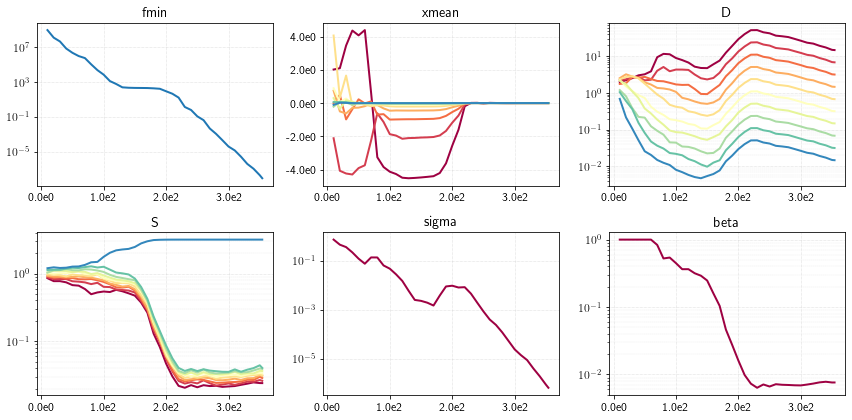

In [7]:
N = 10

# Ellipsoid-Cigar function
def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

def fobj(x):
    return ellcig(x)

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### 共分散行列の表現

以下，解生成分布の共分散行列$\Sigma$を
$$
\Sigma = \sigma^2 D C D
$$
と表現することにする．
$\sigma^2$はステップサイズであり，これまで通りCSAによって更新されるものとする．$D$は対角行列であり，$\sigma^2 D^2$が$\Sigma$の分散行列に対応する．すなわち，$\sigma [D]_{i,i}$が$i$番目の要素の標準偏差に対応する．$C$は対角成分が$1$となる行列であり，$\Sigma$の相関行列に対応する．Separable-CMAでは，$C = I$と固定し，$D$を更新していたと解釈できる．また，CMAでは$DCD$をまとめて更新していたと解釈できる．Diagonal accelerationでは，$D$と$C$を別々に更新することで効率的な学習を可能としている．以下ではこの分解を前提に，話を進めていく．

この共分散行列を用いた場合の解生成は以下の手順で行うことができる．
1. $z_i \sim \mathcal{N}(0, I)$
2. $y_i = \sqrt{C} z_i$
3. $x_i = m + \sigma D y_i$

#### Rank-$\mu$ update を用いた場合の更新式

通常のCMA-ES（$C$を更新する方法）とSeparable-CMA-ES（$D$を更新する方法）において，これまでに紹介してきたRank-$\mu$ updateを用いる場合の更新式をここに示す．Separable-CMA-ESの場合には，$D^2$を更新していくことになるが，ここではその変種として，$D$を更新していくバリエーションを考える．これは文献[1]で示されている方法である．

まず，$D$が固定されており（必ずしも$D = I$でなくてもよい），$C$のみを更新する場合，更新式は
$$
C \leftarrow C + c_\mu \sum_{i=1}^{\lambda} w_{i}\left( y_{i:\lambda}y_{i:\lambda}^\mathrm{T} - C \right)
$$
となる．ここで，rank-$\mu$ update を考える場合には，$w_1 \geq \dots \geq w_\lambda \geq 0$であり，$\sum_{i=1}^{\lambda} w_i = 1$を仮定していたことに注意されたい．

次に，$C = I$が固定されている場合の$D$の更新式は，
$$
\log D^2 \leftarrow \log D^2 + c_{\mu,D} \sum_{i=1}^{\lambda} w_{i}\mathrm{diag}\left( z_{i:\lambda}z_{i:\lambda}^\mathrm{T} - I \right)
$$
と表すことができる．指数関数を一次近似すれば，これまでに紹介したSeparable-CMAの更新式と対応していることが分かる．



## Rank-one update

まず，直感的な説明をする．Rank-$\mu$ update が各イテレーションでの$w_i > 0$となる$\mu$個の解の情報を活用して共分散行列を更新しているのに対し，rank-one update では複数イテレーションを通した解候補の情報を活用することを目的とする．そのため，$\mu$が小さい場合には，rank-one updateの方が情報をより効率的に活用できるようになる．また，rank-one updateではrank-$\mu$ updateでは活用できない符号情報を活用することが可能になる．これについては後述する．

更新式を見ていく．Rank-one update ではCSAでも利用されている進化パスを利用する．ただし，目的が異なるため，進化パスの定義が異なり，
$$
p_C \leftarrow (1 - c_C) p_C + \sqrt{\frac{c_C (2 - c_C)}{\sum_{j=1}^{\lambda} w_j^2} } \sum_{i=1}^{\lambda} w_i y_{i:\lambda}
$$
となる．
Separable-CMA-ESの場合，
$$
p_D \leftarrow (1 - c_D) p_D + \sqrt{\frac{c_D (2 - c_D)}{\sum_{j=1}^{\lambda} w_j^2} } \sum_{i=1}^{\lambda} w_i z_{i:\lambda}
$$
となり，こちらはCSAで利用されている進化パスと用いている累積率$c_D$が異なる点を除いて等しくなる．
これを用いて，$C$や$D$の更新式に，以下の要素を追加する：
$$
c_{1} (p_C p_C^\mathrm{T} - C) \\
c_{1,D} \mathrm{diag}(p_D p_D^\mathrm{T} - I)
$$

この更新式が不偏性を持つ，すなわち，追加した項がランダム関数のもとで期待値0となることは，CSAにおける不偏性の議論と同様にして導かれる．仮にランダムではなく，イテレーションを通して特定の方向の解が選択され続けているような場合，進化パスはそのような方向に対して大きくなるため，その方向への固有値が大きくなることが期待される．

先に述べた，符号情報を活用できる，というのは以下のようなことを意味する．ある解$y_1 = y$と$y_2 = -y$が与えられたとき，rank-$\mu$ updateでは
$$
w_1 (y_1 y_1^\mathrm{T} - C) + w_2 (y_2 y_2^\mathrm{T} - C) = (w_1 + w_2) (y y^\mathrm{T} - C)
$$
であり，$y_1 = y$と$y_2 = y$の場合にも
$$
w_1 (y_1 y_1^\mathrm{T} - C) + w_2 (y_2 y_2^\mathrm{T} - C) = (w_1 + w_2) (y y^\mathrm{T} - C)
$$
である．いずれの場合も，$y$方向に共分散行列の固有値を大きくする影響を持つ．
一方，rank-one updateでは，$y_1 = y$と$y_2 = -y$が与えられたとき，これらがまず進化パスとして累積されるため，この両者の情報は打ち消しあう．そのため，$y$方向に共分散行列の固有値を大きくする影響は持たない．他方，$y_1 = y$と$y_2 = y$が与えられた場合，進化パスが$y$方向に大きくなり，結果として共分散行列を$y$方向に大きくするような影響がある．

#### 検証実験

* Rank-$\mu$ update with/without rank-one update で比較．デフォルトの集団サイズの場合，共分散行列の学習効率や振る舞いに大きな違いが現れることを確認
* lam（集団サイズ）が大きい場合，rank-$\mu$ update がメインになることを確認（各自確認すること）

#### 補足
以下のコードでは，$D$は更新していないが，プログラムの都合上，共分散行列を常に$\sigma^2 D C D$と表現している．毎イテレーションでの$C$の更新後，$C$の対角要素の平方根を$D$に掛け，逆に$C$の左右から$D$に掛けた分の対角行列の逆行列を掛けることで，$C$を相関行列となるように表現している．あくまで実装上の変更であり，アルゴリズム上の違いはない．作図される$S$は相関行列の固有値の平方根，$D$は分散行列の平方根を表す．

#### Rank-$\mu$ update のみ

10 120 16977722.48804556 16844570.854199048
20 240 5024365.99644588 5024365.99644588
30 360 1521418.2278626545 1521418.2278626545
40 480 314320.66445218795 314320.66445218795
50 600 183806.764108705 183806.764108705
60 720 80696.04294416991 80696.04294416991
70 840 31941.97045602993 21587.48463904173
80 960 19103.502530555397 12741.379652114687
90 1080 4863.541333663719 4863.541333663719
100 1200 1632.0697937681075 1632.0697937681075
110 1320 787.1680696151336 577.6397091166059
120 1440 284.68906480373545 259.85371406903784
130 1560 208.87913721734145 167.00212684959087
140 1680 99.38986676448944 81.6332643073783
150 1800 77.85891730883606 55.714372845914895
160 1920 42.5353565904598 39.20626935751338
170 2040 26.99580055634187 26.99580055634187
180 2160 27.73940334011177 25.44025377752645
190 2280 23.823099886002332 23.751360803687728
200 2400 22.671227008458136 22.671227008458136
210 2520 22.312971467692737 22.152471521782033
220 2640 21.81183324539948 21.748725894155516
230 2760 21.

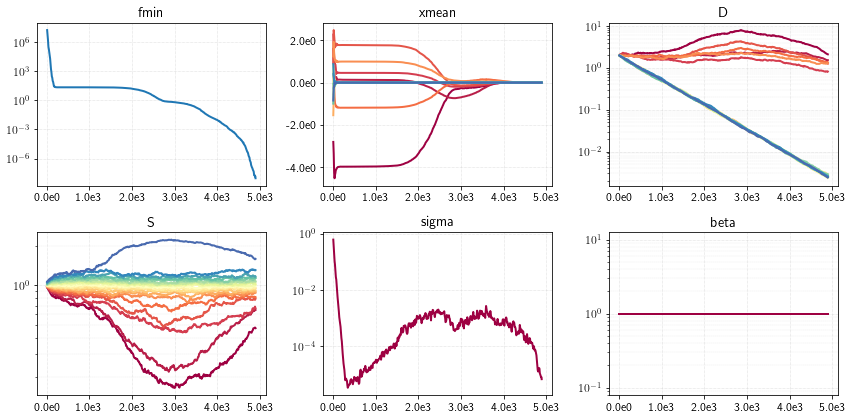

In [15]:
N = 20

def fobj(x):
    k = x.shape[0] // 2
    f = np.sum(x[:, :k] ** 2, axis=1) + 1e6 * np.sum(x[:, k:] ** 2, axis=1)
    return f

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), 
              sigma0=np.ones(N)*2.,
              lam=None,
              flg_covariance_update=True,
              flg_variance_update=False,
              flg_active_update=False)
ddcma.cone = 0  # without rank-one update
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### Rank-$\mu$ update + rank-one update

10 120 20687276.400834817 16019352.661834879
20 240 9164971.053500935 9164971.053500935
30 360 5485301.256594614 5071592.481755282
40 480 2521347.5841081003 2137039.052588604
50 600 455346.18006495596 377851.1375081704
60 720 206629.99391728247 181128.26413367628
70 840 66839.02944141433 66839.02944141433
80 960 20123.63256549379 20123.63256549379
90 1080 12236.130548200616 6652.3565687935525
100 1200 5861.684653294452 5576.316893575573
110 1320 1929.7479865377961 1163.9546933779288
120 1440 806.9390870962393 806.9390870962393
130 1560 458.69171284301365 425.83661727388846
140 1680 275.3678163350415 275.3678163350415
150 1800 256.14894793916466 239.96292273538307
160 1920 219.14164860426504 207.12759029539905
170 2040 188.42297767453414 188.42297767453414
180 2160 188.58018249208828 187.37218081832026
190 2280 185.31508598599117 185.31508598599117
200 2400 184.80383372660913 184.80383372660913
210 2520 184.73456457148566 184.73044296524122
220 2640 184.59331312719542 184.5208104888331


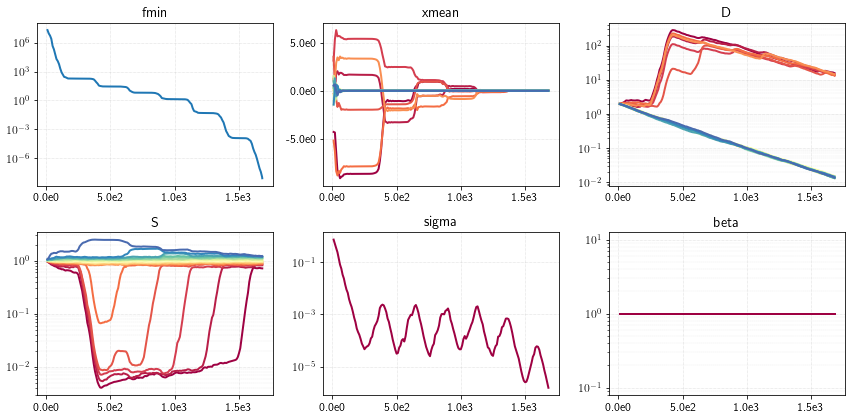

In [14]:
N = 20

def fobj(x):
    k = x.shape[0] // 2
    f = np.sum(x[:, :k] ** 2, axis=1) + 1e6 * np.sum(x[:, k:] ** 2, axis=1)
    return f

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), 
              sigma0=np.ones(N)*2.,
              lam=None,
              flg_covariance_update=True,
              flg_variance_update=False,
              flg_active_update=False)
# ddcma.cone = 0  # without rank-one update
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## Active update

## Diagonal Acceleration